In [20]:
!pip install kaggle

In [21]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

# Move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [22]:
!kaggle datasets download "jangedoo/utkface-new"

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
100% 330M/331M [00:16<00:00, 19.9MB/s]
100% 331M/331M [00:16<00:00, 21.5MB/s]


In [23]:
!unzip utkface-new.zip

Streaming output truncated to the last 5000 lines.
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: utkface_aligned_cropped/crop_part1/34_1_2_20170104204327

In [42]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input
from tqdm.notebook import tqdm

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
BASE_DIR = '/content/UTKFace'

In [27]:
image_paths = []
age_labels = []
gender_labels = []

for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    temp = filename.split('_')
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

In [28]:

df = pd.DataFrame()
df['image'], df['age'], df['gender'] = image_paths, age_labels, gender_labels

In [29]:
gender_dict = {0: 'Male', 1: 'Female'}

In [30]:

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, target_size=(128, 128))
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    return features

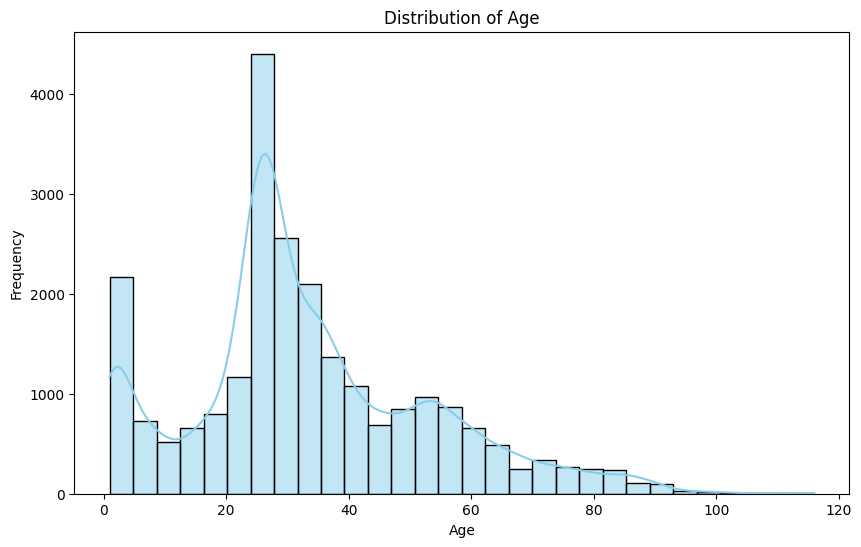

In [43]:
# Distribution of Age
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


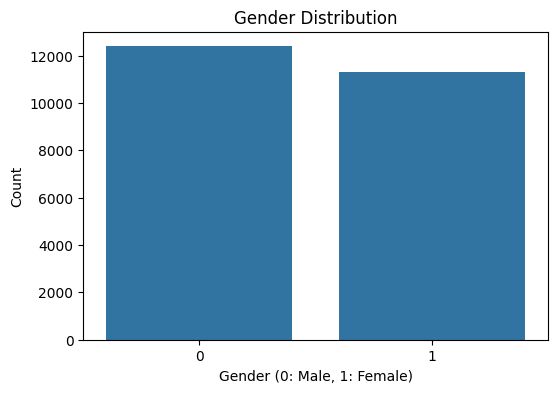

In [44]:
# Gender Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='gender', data=df)
plt.title('Gender Distribution')
plt.xlabel('Gender (0: Male, 1: Female)')
plt.ylabel('Count')
plt.show()

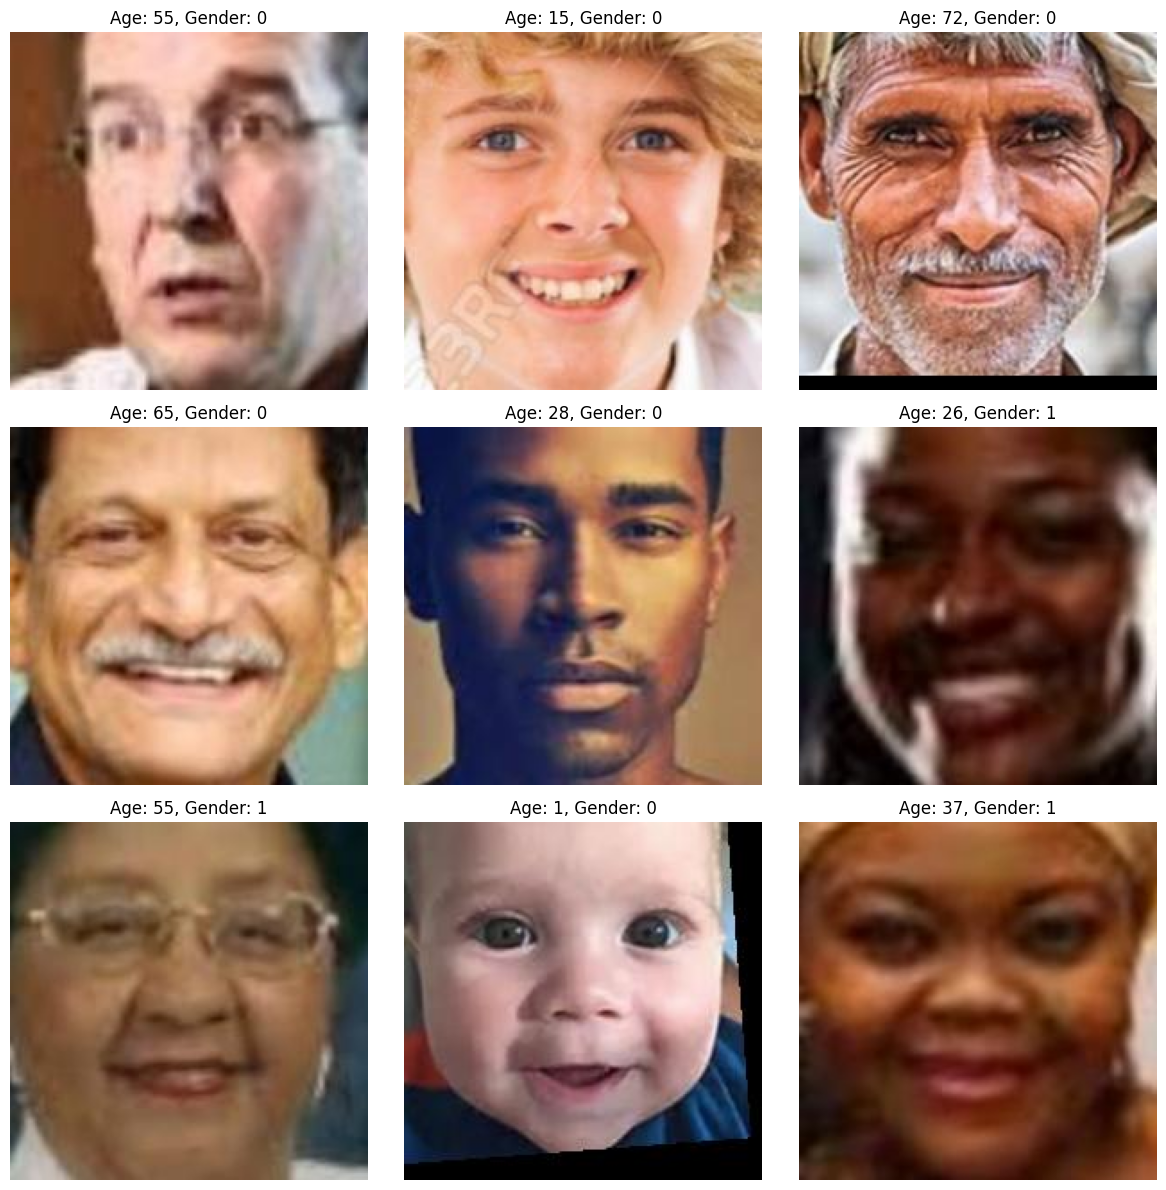

In [45]:
# Display a few sample images
plt.figure(figsize=(12, 12))
sample_images = df.sample(9)
for i, (_, row) in enumerate(sample_images.iterrows(), 1):
    plt.subplot(3, 3, i)
    img = plt.imread(row['image'])
    plt.imshow(img)
    plt.title(f"Age: {row['age']}, Gender: {row['gender']}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [32]:
# Define VGG-16 base model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

In [33]:
# Freeze convolutional layers
for layer in vgg_base.layers:
    layer.trainable = False

In [34]:
# Add custom top layers for age and gender prediction
x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(x)
age_output = Dense(1, activation='linear', name='age_output')(x)


In [35]:
# Combine model
model = Model(inputs=vgg_base.input, outputs=[gender_output, age_output])

In [36]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001),
              loss={'gender_output': 'binary_crossentropy', 'age_output': 'mae'},
              metrics={'gender_output': 'accuracy', 'age_output': 'mae'})


In [37]:
# Train/validation split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [38]:
# ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [39]:
# Flow from DataFrame
train_generator = train_datagen.flow_from_dataframe(dataframe=train_df, x_col='image', y_col=['gender', 'age'],
                                                    class_mode='raw', target_size=(128, 128), batch_size=32)
val_generator = val_datagen.flow_from_dataframe(dataframe=val_df, x_col='image', y_col=['gender', 'age'],
                                                class_mode='raw', target_size=(128, 128), batch_size=32)

Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [40]:
# Train the model
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    epochs=30,
                    validation_data=val_generator,
                    validation_steps=len(val_generator))


Epoch 1/30
593/593 [==============================] - 48s 63ms/step - loss: -668470.3125 - gender_output_loss: -668501.9375 - age_output_loss: 31.8904 - gender_output_accuracy: 0.2630 - age_output_mae: 31.8904 - val_loss: -2047599.3750 - val_gender_output_loss: -2047616.0000 - val_age_output_loss: 17.1866 - val_gender_output_accuracy: 0.2597 - val_age_output_mae: 17.1866
Epoch 2/30
593/593 [==============================] - 33s 55ms/step - loss: -4677662.0000 - gender_output_loss: -4677686.0000 - age_output_loss: 25.6543 - gender_output_accuracy: 0.2630 - age_output_mae: 25.6543 - val_loss: -7958573.0000 - val_gender_output_loss: -7958607.5000 - val_age_output_loss: 33.1719 - val_gender_output_accuracy: 0.2597 - val_age_output_mae: 33.1719
Epoch 3/30
593/593 [==============================] - 34s 57ms/step - loss: -12172242.0000 - gender_output_loss: -12172281.0000 - age_output_loss: 38.4254 - gender_output_accuracy: 0.2630 - age_output_mae: 38.4254 - val_loss: -17061230.0000 - val_gen

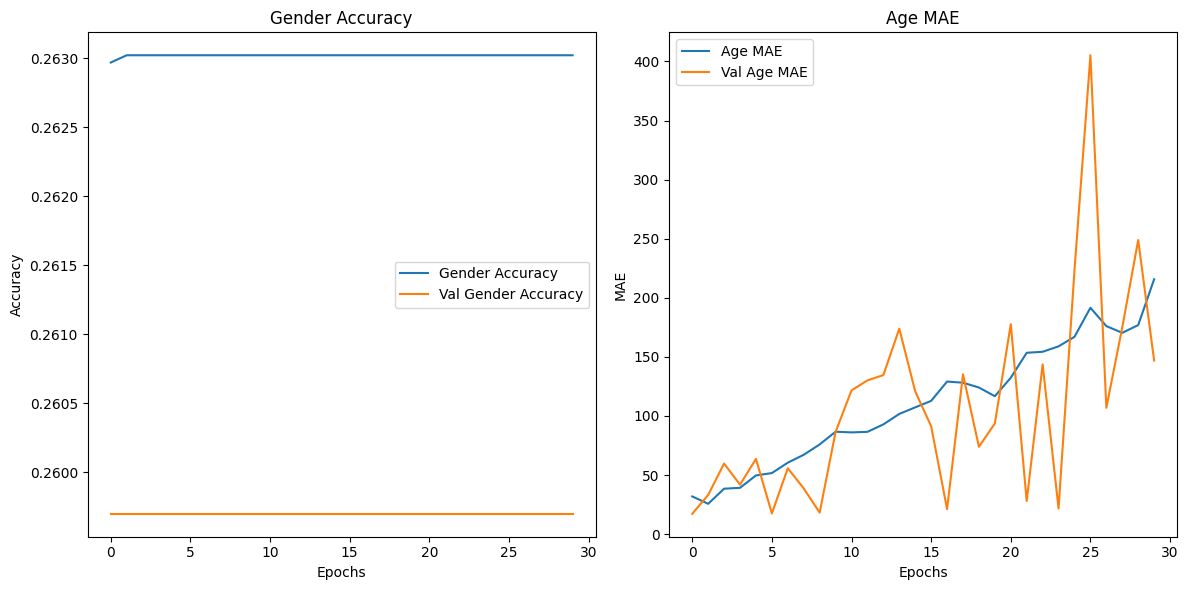

In [41]:

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['gender_output_accuracy'], label='Gender Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Gender Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['age_output_mae'], label='Age MAE')
plt.plot(history.history['val_age_output_mae'], label='Val Age MAE')
plt.title('Age MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

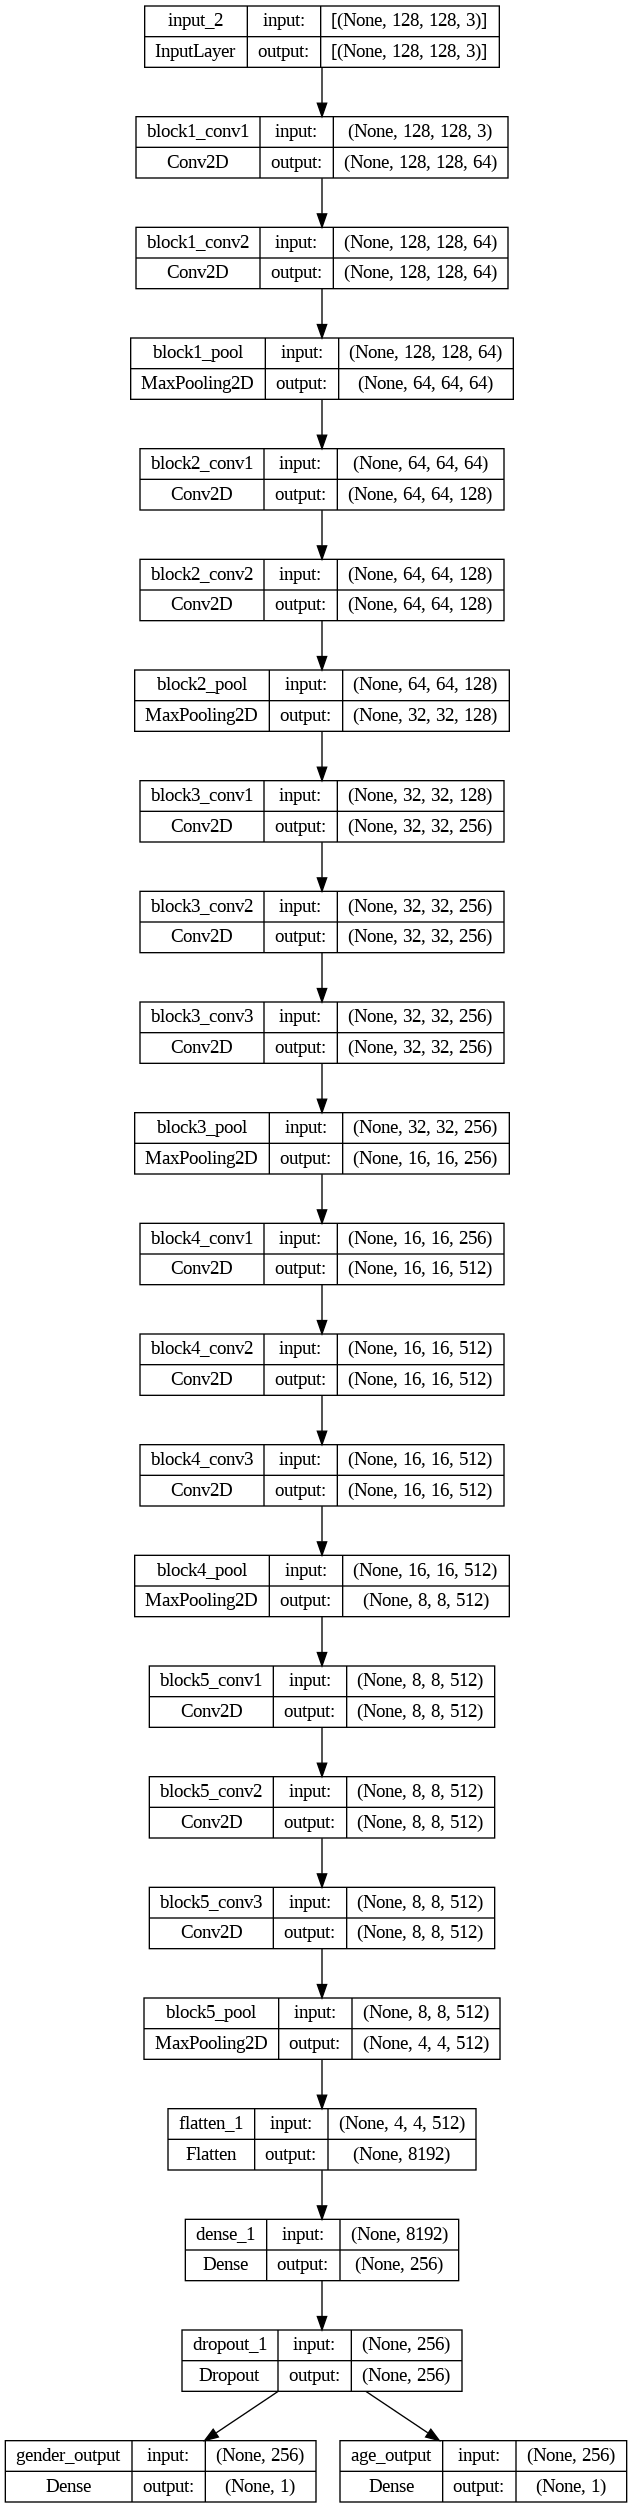

In [46]:
from keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


1/1 [==============================] - 2s 2s/step
Original Gender: Female Original Age: 40
Predicted Gender: Female Predicted Age: 147


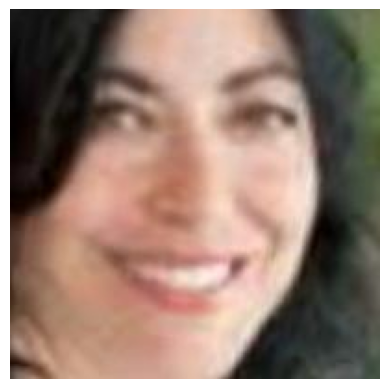

In [47]:
# Prediction with Test Data
image_index = 56  # Example index, you can change it as needed

# Load and preprocess the test image
test_image_path = df['image'][image_index]
test_image = tf.keras.preprocessing.image.load_img(test_image_path, target_size=(128, 128))
test_image = tf.keras.preprocessing.image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
test_image /= 255.0  # Normalize

# Predict from the model
gender_pred, age_pred = model.predict(test_image)

# Decode gender prediction
gender_label = "Male" if gender_pred[0][0] < 0.5 else "Female"

# Decode age prediction
age_pred = int(round(age_pred[0][0]))

# Original labels
original_gender = "Male" if df['gender'][image_index] == 0 else "Female"
original_age = df['age'][image_index]

# Print predictions
print("Original Gender:", original_gender, "Original Age:", original_age)
print("Predicted Gender:", gender_label, "Predicted Age:", age_pred)

# Display the image
plt.axis('off')
plt.imshow(tf.keras.preprocessing.image.load_img(test_image_path))
plt.show()
